#**PART 1**
 **(Creating Baseline Binary Skin Lesion Classification Model)**

*We will use only skin lesion images for binary classification- whether the skin lesion is malignant(causing cancer) or benign(non-cancerous).*

###Pre-Processing

In [ ]:
#Downloading dataset HAM10000 using kaggle -

from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/data_folder

In [ ]:
#Importing required libraries,modules and checking versions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
# Import modules and check versions
import google
import glob
import itertools
import os
import pickle
import PIL
import seaborn as sns
from glob import glob
from google.colab import drive
from PIL import Image
from platform import python_version
from google.colab import drive
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from numpy import expand_dims
from platform import python_version

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()   
print("Version Matplotlib:",matplotlib.__version__)
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version PIL:",PIL.__version__)
print("Version Seaborn:",sns.__version__)
print("Version TensorFlow:",tf.__version__)


Version Python: 3.9.16

Version Matplotlib: 3.7.1
Version NumPy: 1.22.4
Version Pandas: 1.4.4
Version PIL: 8.4.0
Version Seaborn: 0.12.2
Version TensorFlow: 2.11.0


In [ ]:
#Some other Installations-
!pip install imbalanced-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/data_folder/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Data inspection: outlier and missing data detection and handling

#Unique values per column 
for col in metadata:
    print(metadata[col].nunique(),"unique values in " + col + ":",np.sort(metadata[col].unique()))
print()


7470 unique values in lesion_id: ['HAM_0000000' 'HAM_0000001' 'HAM_0000002' ... 'HAM_0007626' 'HAM_0007627'
 'HAM_0007628']
10015 unique values in image_id: ['ISIC_0024306' 'ISIC_0024307' 'ISIC_0024308' ... 'ISIC_0034318'
 'ISIC_0034319' 'ISIC_0034320']
7 unique values in dx: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
4 unique values in dx_type: ['confocal' 'consensus' 'follow_up' 'histo']
18 unique values in age: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 nan]
3 unique values in sex: ['female' 'male' 'unknown']
15 unique values in localization: ['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']



In [ ]:
# Missing values ('NA' or 'unknown') 
print("Number of 'NA' in 'age':", metadata['age'].isna().sum())
print("Number of 'unknown' in 'sex':", len(metadata[metadata['sex']=='unknown']))
print("Number of 'unknown' in 'localization':", len(metadata[metadata['localization']=='unknown']))
print()


Number of 'NA' in 'age': 57
Number of 'unknown' in 'sex': 57
Number of 'unknown' in 'localization': 234



We have 57 null values in age.Dropping these values can cause loss of metadata.
Let's replace them with mean age 

In [ ]:
# Drop instances where values for 'age', 'sex', and 'localization' are all missing  
initial_length = len(metadata)

metadata['age'].fillna(metadata['age'].mean(),inplace=True)
metadata = metadata.drop(metadata[(metadata['localization'] == 'unknown') & (metadata['sex'] == 'unknown')].index)
# Missing values ('NA' or 'unknown') 
print("Number of 'NA' values in 'age' column :", metadata['age'].isna().sum())
print("Number of 'unknown' values in 'sex' column:", len(metadata[metadata['sex']=='unknown']))
print("Number of 'unknown' in 'localization'column :", len(metadata[metadata['localization']=='unknown']))
print()


Number of 'NA' values in 'age' column : 0
Number of 'unknown' values in 'sex' column: 10
Number of 'unknown' in 'localization'column : 187



In [ ]:
# Percentage missing (after initial drop)
print("Number of instances with multiple missing values :",sum((len(metadata[(metadata['sex'] == 'unknown') & (metadata['localization'] == 'unknown')].index),len(metadata[(metadata['sex'] == 'unknown') & (metadata['age'].isna())].index),len(metadata[(metadata['localization'] == 'unknown') & (metadata['age'].isna())].index))))
print("Percentage of missing cases for 'age':", round((metadata['age'].isna().sum()/initial_length*100),1),"%")
print("Percentage of missing cases for 'sex':", round((len(metadata[metadata['sex'] == 'unknown'])/initial_length*100),1),"%")
print("Percentage of missing cases for 'localization':", round((len(metadata[metadata['localization'] == 'unknown'])/initial_length*100),1),"%")
print()

# Drop all remaining rows containing NA's (10) and rows containing value 'unknown' (10 + 187)  
metadata = metadata.dropna()
metadata = metadata[metadata.sex != 'unknown']
metadata = metadata[metadata.localization != 'unknown']
print("Percentage of complete cases:", round((len(metadata)/initial_length*100),1),"%")



Number of instances with multiple missing values : 0
Percentage of missing cases for 'age': 0.0 %
Percentage of missing cases for 'sex': 0.1 %
Percentage of missing cases for 'localization': 1.9 %

Percentage of complete cases: 97.6 %


In [ ]:
#Checking null values-
metadata.head(974)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
989,HAM_0000613,ISIC_0031253,bkl,consensus,60.0,male,hand
990,HAM_0005101,ISIC_0024643,bkl,consensus,35.0,male,abdomen
991,HAM_0002355,ISIC_0029202,bkl,consensus,35.0,male,abdomen
992,HAM_0006912,ISIC_0026205,bkl,consensus,35.0,male,back


In [ ]:
# Create dictionaries of full name of lesions, type of lesion, localization and image paths
lesions = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}
#codes for all multiple lesion classses
lesion_classes_dict ={
    0:'akiec',
    1:'bcc',
    2:'bkl',
    3:'df',
    4:'nv',
    5:'mel',
    6:'vasc'
}
#malignant skin lesion can cause cancer .
lesion_type = {
    'akiec': 'Malignant',
    'bcc': 'Malignant', 
    'bkl': 'Benign',
    'df': 'Benign',
    'mel': 'Malignant',
    'nv': 'Benign',
    'vasc': 'Benign'   
}
#Sun exposed and no-sun areas of the body
localizations = {
    'abdomen': 'No Sun',
    'acral': 'No Sun',
    'back': 'No Sun',
    'chest': 'No Sun',
    'ear': 'Sun',
    'face': 'Sun',
    'foot': 'No Sun',
    'genital': 'No Sun',
    'hand': 'Sun',
    'lower extremity': 'Sun',
    'neck': 'Sun',
    'scalp': 'Sun',
    'trunk': 'No Sun',
    'upper extremity': 'Sun'
}

In [ ]:
ham_data_folder = '../content/data_folder'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ham_data_folder, '*', '*.jpg'))}
 

In [ ]:
metadata['dx_full'] = metadata['dx'].map(lesions.get) 
metadata['dx_cat'] = pd.Categorical(metadata['dx_full']).codes
metadata['image_path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['lesion_type'] = metadata['dx'].map(lesion_type.get) 
metadata['lesion_type_cat'] = pd.Categorical(metadata['lesion_type']).codes
metadata.loc[metadata['age'] >= 50, 'age_group'] = 'Older'
metadata['age_group'] = metadata['age_group'].fillna('Younger')
metadata['age_cat'] = pd.Categorical(metadata['age_group']).codes
metadata['sex_cat'] = pd.Categorical(metadata['sex']).codes
metadata['loc_group'] =metadata['localization'].map(localizations.get) 
metadata['loc_cat'] = pd.Categorical(metadata['loc_group']).codes

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full,dx_cat,image_path,lesion_type,lesion_type_cat,age_group,age_cat,sex_cat,loc_group,loc_cat
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../content/data_folder/ham10000_images_part_1/...,Benign,0,Older,0,1,Sun,1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../content/data_folder/ham10000_images_part_1/...,Benign,0,Older,0,1,Sun,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../content/data_folder/ham10000_images_part_1/...,Benign,0,Older,0,1,Sun,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../content/data_folder/ham10000_images_part_1/...,Benign,0,Older,0,1,Sun,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,../content/data_folder/ham10000_images_part_2/...,Benign,0,Older,0,1,Sun,1


In [ ]:
images_per_lesion = metadata["lesion_id"].value_counts()

def unique(x):  
    if images_per_lesion[x] > 1:
        return False
    else:
        return True

metadata["unique"] = metadata["lesion_id"].map(unique)

metadata = metadata[['lesion_id','image_id','unique','dx','dx_full','dx_cat','lesion_type','lesion_type_cat','dx_type','age','age_group','age_cat','sex','sex_cat','localization','loc_group','loc_cat','image_path']]

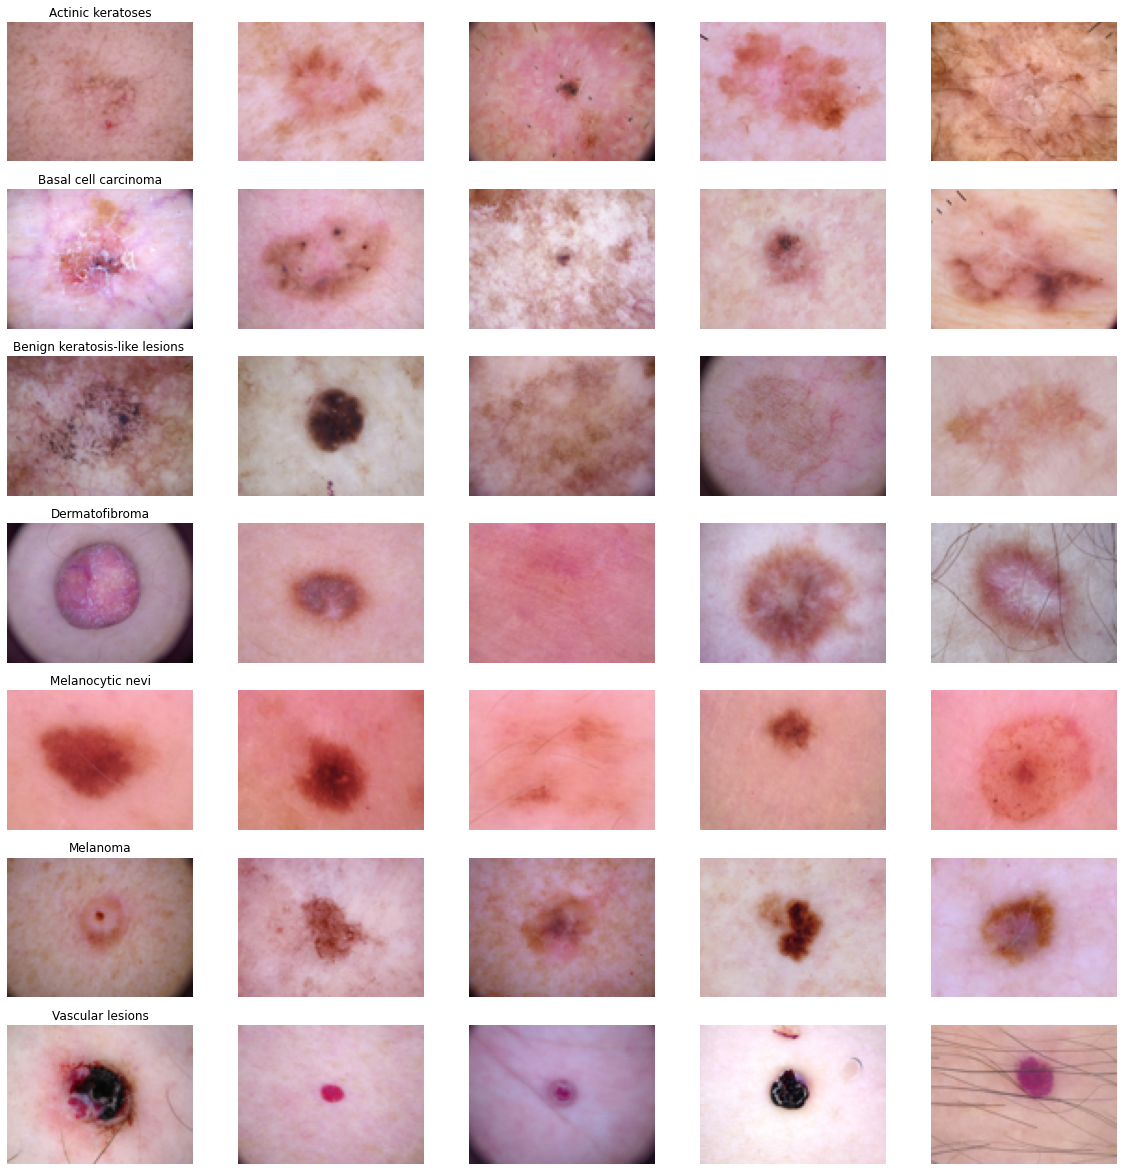

In [ ]:
# Add images to dataframe and output samples of all lesion types 
# (Derived from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy)

# Add images to dataframe and resize images from 600x450 to 100x75
metadata['image'] = metadata['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# Samples of each lesion type
fig, m_axs = plt.subplots(7, 5, figsize = (4*5, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,metadata.sort_values(['dx_full']).groupby('dx_full')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

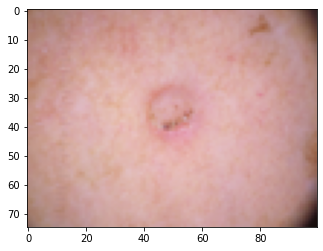

In [ ]:
plt.imshow(metadata['image'][7])

In [ ]:
#Pickle serializes the python objects so they can be saved in a file (like byte stream)and loaded in a program whenever we want in formats 

pd.to_pickle(metadata, os.path.join('/content/data_folder', 'data.pkl'))

#Model

In [ ]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [ ]:
metadata = pd.read_pickle(os.path.join('/content/data_folder', 'data.pkl'))

In [ ]:
#Create training, validation amd test sets (Derived from: https://www.kaggle.com/kaimingk/skin-cancer-mnist-ham10000)

# Split 70%, 10%, 20%. Test and validation, together 30%, should be from unique ID's only
size_val_test = 0.3 * len(metadata)
val_test_ratio_from_unique = size_val_test/len(metadata[metadata.unique == True])

# Training data = remainder of unique ID's + non-uniques. Split is stratified by lesion type (benign/malignant)
bb_metadata_train_unique, bb_metadata_val_test = train_test_split(metadata[metadata["unique"] == True], test_size = val_test_ratio_from_unique, stratify=metadata[metadata["unique"] == True]["lesion_type_cat"], random_state = 42)
bb_metadata_train = pd.concat((bb_metadata_train_unique, metadata[metadata["unique"] == False]), axis = 0)

# Split validation and test sets. Split is stratified by lesion type (benign/malignant)
bb_metadata_validation, bb_metadata_test = train_test_split(bb_metadata_val_test, test_size = 0.6667, stratify=bb_metadata_val_test["lesion_type_cat"], random_state = 42)

# Class balancing (random oversampling)
X = bb_metadata_train.drop(['lesion_type_cat'], axis=1)
y = bb_metadata_train['lesion_type_cat']

X_test = bb_metadata_test.drop(['lesion_type_cat'], axis=1)
y_test = bb_metadata_test['lesion_type_cat']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

bb_metadata_train = pd.concat([X_resampled, y_resampled], axis=1)
bb_metadata_test = pd.concat([X_test_resampled, y_test_resampled], axis=1)

# Create variables for feature (x) and target (y) training, validation and test sets
bb_metadata_train_x = np.asarray(bb_metadata_train['image'].tolist())
bb_metadata_validation_x = np.asarray(bb_metadata_validation['image'].tolist())
bb_metadata_test_x = np.asarray(bb_metadata_test['image'].tolist())

bb_metadata_train_y = np.asarray(bb_metadata_train['lesion_type_cat'].tolist())
bb_metadata_validation_y = np.asarray(bb_metadata_validation['lesion_type_cat'].tolist())
bb_metadata_test_y = np.asarray(bb_metadata_test['lesion_type_cat'].tolist())

# One-hot encoding of target variable
bb_num_classes = len(np.sort(metadata['lesion_type_cat'].unique()))

bb_metadata_train_y = to_categorical(bb_metadata_train_y, num_classes = bb_num_classes)
bb_metadata_validation_y = to_categorical(bb_metadata_validation_y, num_classes = bb_num_classes)
bb_metadata_test_y = to_categorical(bb_metadata_test_y, num_classes = bb_num_classes)

In [ ]:
print("Train: " + str(bb_metadata_train.shape[0] / metadata.shape[0]))
print("Validation: " + str(bb_metadata_validation.shape[0] / metadata.shape[0]))
print("Test: " + str(bb_metadata_test.shape[0] /metadata.shape[0]))

Train: 1.065192917818033
Validation: 0.0999897656329956
Test: 0.35861221983420327


###Performing Data Augmentation

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,  
    vertical_flip = True,  
    shear_range = 10)

In [ ]:
# Fit data augmentation
data_augmentation.fit(bb_metadata_train_x)

###CNN model -

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 23, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 17, 23, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 11, 96)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 11, 256)        614656    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 11, 256)       1024

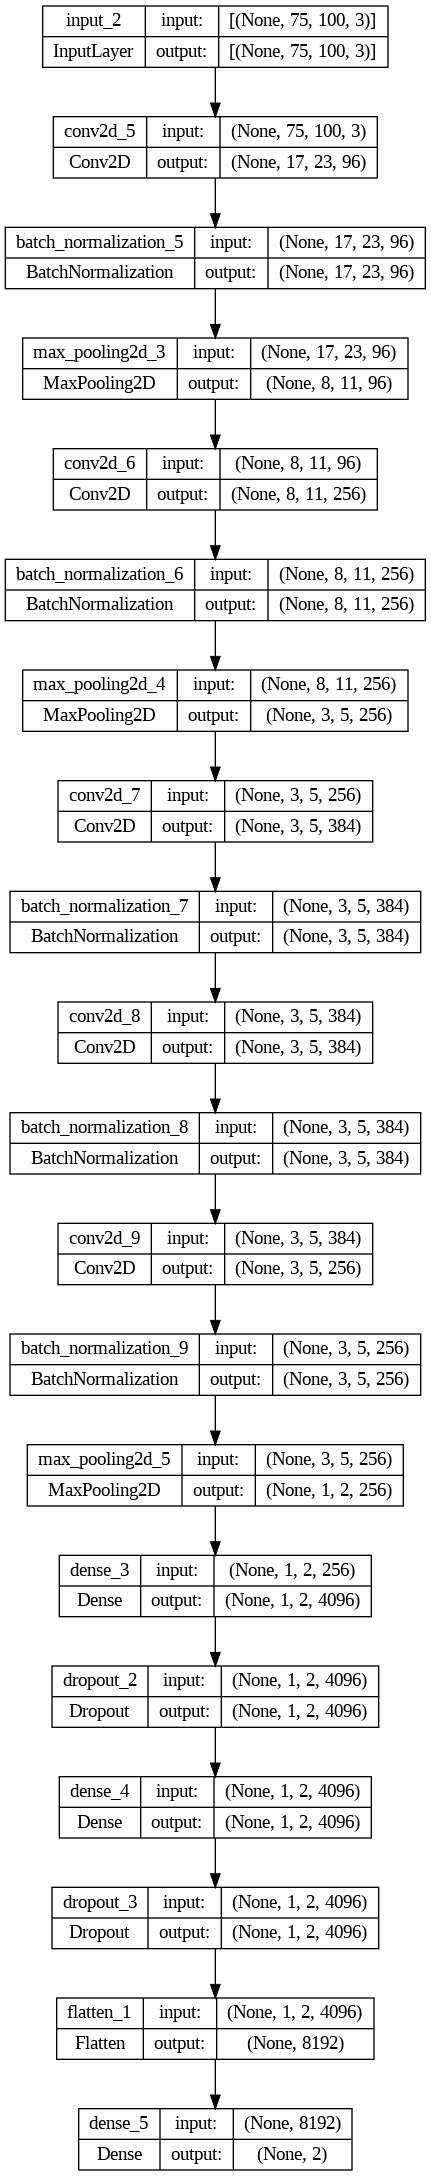

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Input,MaxPooling2D,Conv2D
from tensorflow.keras.utils import plot_model

# Model parameters
input_shape = (75, 100, 3)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 100
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.000001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Create CNN
inp1 = Input(input_shape)
# 1st convolutional layer
x1=Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu')(inp1)
x1=BatchNormalization()(x1)
x1=MaxPooling2D(pool_size=(3,3), strides=(2,2))(x1)

# 2nd convolutional layer
x1=Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x1)
x1=BatchNormalization()(x1)
x1=MaxPooling2D(pool_size=(3,3), strides=(2,2))(x1)
 
# 3rd convolutional layer
x1=Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x1)
x1=BatchNormalization()(x1)
    
# 4th convolutional layer
x1=Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x1)
x1=BatchNormalization()(x1)

# 5th convolutional layer
x1=Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x1)
x1=BatchNormalization()(x1)
x1=MaxPool2D(pool_size=(3,3), strides=(2,2))(x1)

x1=Dense(4096, activation='relu')(x1)
x1=Dropout(0.2)(x1)

x1=Dense(4096, activation='relu')(x1)
x1=Dropout(0.2)(x1)
x1=Flatten()(x1)
   
output = Dense(2, activation='sigmoid')(x1)

# Create final model
Unimodal_binary_model = Model(inputs=inp1, outputs=output)

# Compile model  
Unimodal_binary_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])

# Output model architecture
print(Unimodal_binary_model.summary())
plot_model(Unimodal_binary_model, to_file=os.path.join('/content/data_folder', 'unimodal_architecture.png'),show_shapes = True)


In [ ]:
Unimodal_binary_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 23, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 17, 23, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 11, 96)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 11, 256)        614656    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 11, 256)       1024

**Model Architecture-**

**Train and save model**

In [ ]:
# Fit and save model 
UnimodalBinary_history = Unimodal_binary_model.fit(data_augmentation.flow(bb_metadata_train_x,bb_metadata_train_y, batch_size=batch_size),
                        epochs = epochs, validation_data = (bb_metadata_validation_x,bb_metadata_validation_y),
                        verbose = 1, steps_per_epoch=bb_metadata_train_x.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])


Epoch 1/100
325/325 [==============================] - 29s 85ms/step - loss: 0.7505 - accuracy: 0.6233 - val_loss: 0.4199 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 2/100
325/325 [==============================] - 33s 102ms/step - loss: 0.5786 - accuracy: 0.6754 - val_loss: 1.0356 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 3/100
325/325 [==============================] - 26s 78ms/step - loss: 0.5603 - accuracy: 0.6993 - val_loss: 0.4092 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 4/100
325/325 [==============================] - 26s 81ms/step - loss: 0.5574 - accuracy: 0.7061 - val_loss: 0.4315 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 5/100
325/325 [==============================] - 25s 78ms/step - loss: 0.5461 - accuracy: 0.7104 - val_loss: 0.1891 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 6/100
325/325 [==============================] - 37s 113ms/step - loss: 0.5242 - accuracy: 0.7328 - val_loss: 0.2142 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 7/100
325/325 [=============================

In [ ]:
Unimodal_binary_model.save(os.path.join('/content/data_folder',"Baseline_binary_model"))

#Model Evaluation

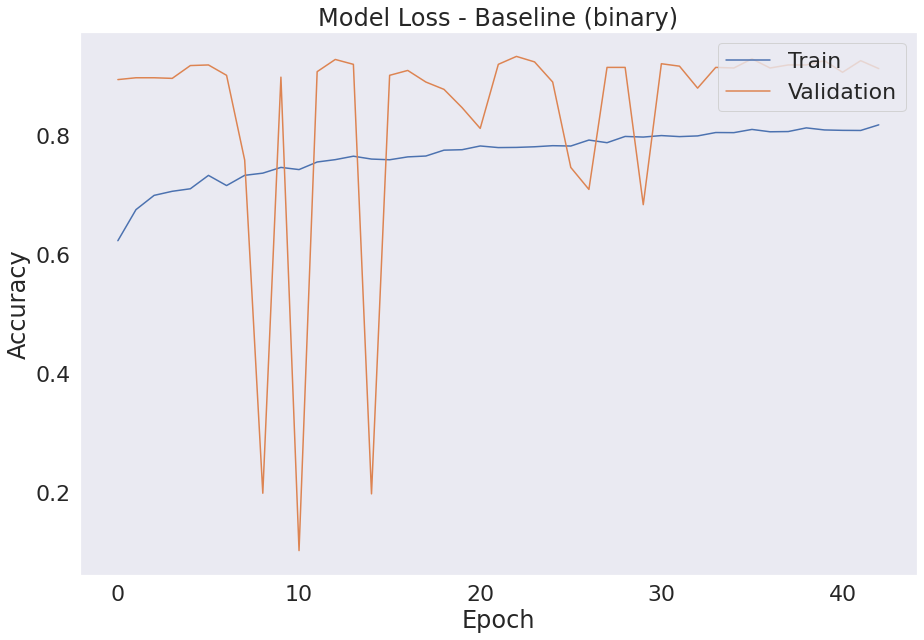

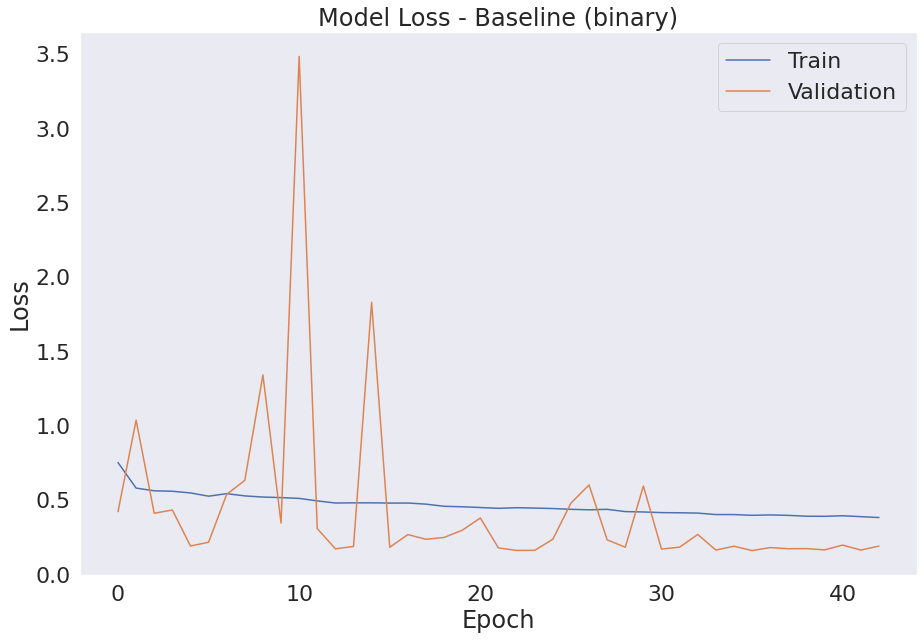

In [ ]:
# Accuracy over epochs
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss - Baseline (binary)')
plt.grid(None)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Baseline (binary).png')
plt.savefig(os.path.join('/content/data_folder',filename), dpi=600)
plt.show()

# Loss over epochs
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Baseline (binary)')
plt.grid(None)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Baseline (binary).png')
plt.savefig(os.path.join('/content/data_folder',filename), dpi=600)
plt.show()

In [ ]:
bb_y_test = np.argmax(bb_metadata_test_y, axis=1)
bb_y_pred_probs = Unimodal_binary_model.predict(bb_metadata_test_x)
bb_y_pred = np.array(list(map(lambda x: np.argmax(x), bb_y_pred_probs)))

110/110 [==============================] - 2s 9ms/step


In [ ]:
bb_loss_train, bb_accuracy_train = Resnet50model_UnimodalBinary.evaluate(bb_metadata_train_x, bb_metadata_train_y, verbose=1)
bb_loss_validation, bb_accuracy_validation = Resnet50model_UnimodalBinary.evaluate(bb_metadata_validation_x, bb_metadata_validation_y, verbose=1)
bb_loss_test, bb_accuracy_test = Resnet50model_UnimodalBinary.evaluate(bb_metadata_test_x, bb_metadata_test_y, verbose=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( bb_y_test,bb_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1752
           1       0.89      0.88      0.88      1752

    accuracy                           0.89      3504
   macro avg       0.89      0.89      0.89      3504
weighted avg       0.89      0.89      0.89      3504



In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Precision score: {}".format(precision_score(bb_y_test,bb_y_pred)))
print("F1 score: {}".format(f1_score(bb_y_test,bb_y_pred)))
print("Roc_Auc_score :{}".format(roc_auc_score(bb_y_test, bb_y_pred,average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)))


Precision score: 0.8911407064273307
F1 score: 0.8847369933889048
Roc_Auc_score :0.8855593607305936


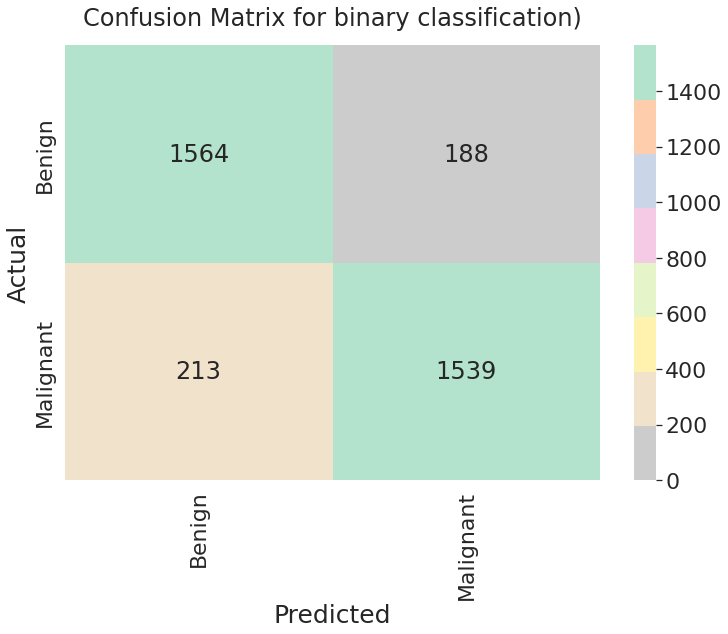

In [ ]:
lesion_types= ['Benign','Malignant']
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(bb_y_test,bb_y_pred),columns = lesion_types, index = lesion_types)
plt.figure(figsize=(12,8))
sns.set(font_scale=2.0)
ax = sns.heatmap(conf_matrix, annot = True, fmt = 'g' ,vmin = 0,cmap = 'Pastel2_r')
ax.set_xlabel('Predicted',fontsize = 25)
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize =25)    
ax.set_title('Confusion Matrix for binary classification)',fontsize =24,pad=20);
filename = 'Confusion Matrix(binary)'
plt.savefig(os.path.join('/content/data_folder',filename), dpi=600)
plt.show()

# Testing instances and Grad-CAM Implementation

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
#Ref- https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]
    
        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
func_model = Unimodal_binary_model

In [ ]:
for idx in range(len(func_model.layers)):
  print(func_model.get_layer(index = idx).name)

input_2
conv2d_5
batch_normalization_5
max_pooling2d_3
conv2d_6
batch_normalization_6
max_pooling2d_4
conv2d_7
batch_normalization_7
conv2d_8
batch_normalization_8
conv2d_9
batch_normalization_9
max_pooling2d_5
dense_3
dropout_2
dense_4
dropout_3
flatten_1
dense_5


In [ ]:
def test_image(imgpath):
  image = cv2.imread(imgpath) #195X285X3
  image = cv2.resize(image, (100,75))
  image = image.astype('float32') / 255
  image = np.expand_dims(image, axis=0)
  preds =func_model.predict(image) 
  print('Prediction probability:',preds)
  i = np.argmax(preds[0])
  print('Predicted class:',i)
  icam = GradCAM(func_model, i, 'conv2d_9') 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (75,100))
  image = cv2.imread(imgpath)
  image = cv2.resize(image, (75,100))
  print(heatmap.shape, image.shape)
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
  fig, ax = plt.subplots(1, 3,figsize=(13,6))
  plt.axis('off')
  plt.grid(None)
  ax[0].imshow(heatmap)
  ax[1].imshow(image)
  ax[2].imshow(output)

1/1 [==============================] - 0s 25ms/step
Prediction probability: [[0.8077777  0.16608675]]
Predicted class: 0
(100, 75) (100, 75, 3)


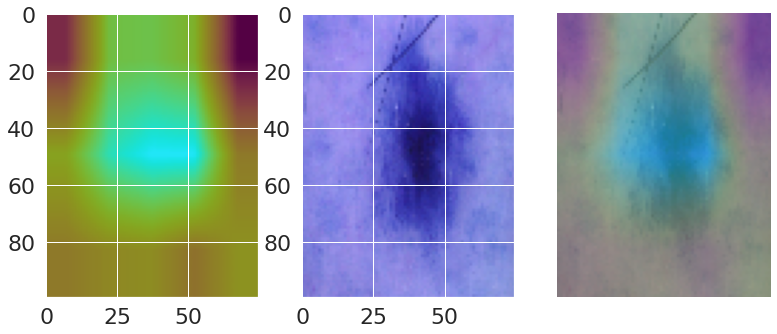

In [ ]:
test_image('/content/test_nv.jpg')

1/1 [==============================] - 0s 23ms/step
Prediction probability: [[0.80873626 0.16477953]]
Predicted class: 0
(100, 75) (100, 75, 3)


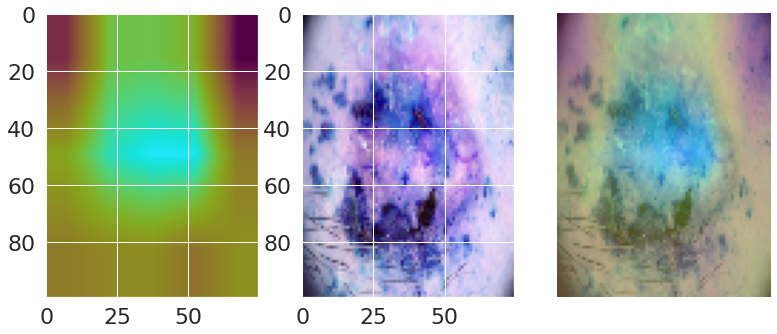

In [ ]:
test_image('/content/malignant_test_image.jpg')

In [ ]:
test_image = np.asarray(pil_image.open('/content/'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

Actual Output: Benign
Predicted Output: Benign
Non Cancerous Skin Lesion


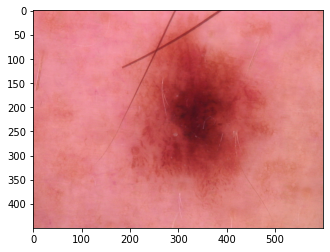

In [ ]:
prediction_class = Unimodal_binary_model.predict(test_image2)
prediction_class = np.argmax(prediction_class,axis=1)
prediction_class

df2 = pd.DataFrame(metadata)
df3=df2[df2['lesion_type_cat']==0]['lesion_type']

plt.imshow(test_image)
if(df3[0]=='Malignant'):
  x='Cancerous Skin Lesion'
else:
  x='Non Cancerous Skin Lesion'
  print('Actual Output:',lesion_type['nv'])
  print('Predicted Output:',df3[0])
  print(x)

Original Shape of image is :  (195, 258, 3)


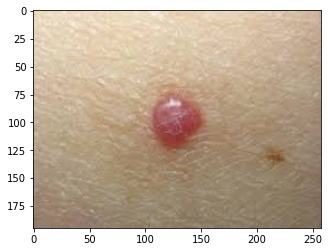

In [ ]:
test_image = np.asarray(pil_image.open('/content/test_image.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [ ]:
resized_image2 = np.asarray(pil_image.open('/content/test_image.jpg').resize((100,75)))
image_array = np.asarray(resized_image2.tolist())
test_image = image_array.reshape(1,75,100,3)

New Shape of image is :  (75, 100, 3)


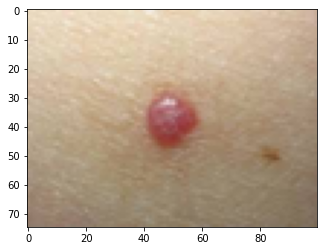

In [ ]:
plt.imshow(resized_image2)
print('New Shape of image is : ',resized_image.shape)

In [ ]:
pc1 = Unimodal_binary_model.predict(test_image2)
#print(pc1)
pc2 = np.argmax(pc1,axis=1)
print('Predicted class is', pc2, 'with', pc1[0][0]*100,' % probability')

1/1 [==============================] - 0s 24ms/step
Predicted class is [0] with 99.89629983901978  % probability


In [ ]:
X_test_resampled.iloc[2661]['image_path']

'../content/data_folder/ham10000_images_part_2/ISIC_0032466.jpg'

In [ ]:
resized_image3 = np.asarray(pil_image.open('../content/data_folder/HAM10000_images_part_2/ISIC_0032466.jpg').resize((100,75)))
image_array3= np.asarray(resized_image3.tolist())
malignant_test_image = image_array3.reshape(1,75,100,3)

New Shape of image is :  (75, 100, 3)


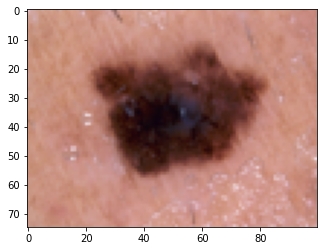

In [ ]:
plt.imshow(resized_image3)
print('New Shape of image is : ',resized_image3.shape)

In [ ]:
pc3 = Unimodal_binary_model.predict(malignant_test_image)
#print(pc1)
pc4 = np.argmax(pc3,axis=1)
print('Predicted class is', pc3, 'with', pc3[0][1]*100,' % probability')

1/1 [==============================] - 0s 39ms/step
Predicted class is [[0.5506759  0.43214336]] with 43.2143360376358  % probability
